# Crime in San Diego

Cleaned by Megan Chang

This file contains information about crime in the city of San Diego. The data used (San Diego Region Crime Incidents 2007 - 2013) is from the San Diego Regional Data Library. The specific values extracted from the data set includes year, neighborhood, and crime incident. From the given neighborhoods, corresponding zip codes were appended to the data. Using these details, visuals provided insight for the general trend in crime levels for each zip code over the years.


In [850]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as io
import scipy.signal as sig
import math as math
import random 
from scipy import integrate
import matplotlib.pyplot as plt
import h5py

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams['image.cmap'] = 'RdBu'

from mpl_toolkits.mplot3d import Axes3D

# 1. Clean data

Read data sets of crime, zip codes, and neighborhood codes. Clean out unecessary information and append zip codes to corresponding neighborhoods. Group data to get total crime for particular year and zipcode.

In [851]:
dfcrime = pd.read_csv('incidents_100k.csv')
dfcode = pd.read_csv('nbrhcodes.csv')
dfzip = pd.read_csv('area_zip_dict.csv')

In [852]:
#examine data from crime incidents
print(dfcrime.head(5))

   id        date  year  month   day  week  dow      time  hour  is_night  \
0 NaN  2008-09-19  2008      9  3184    37    5  13:00:00    13         0   
1 NaN  2008-07-20  2008      7  3123    28    0  22:00:00    22         1   
2 NaN  2009-05-25  2009      5  3432    21    1  00:30:00     0         1   
3 NaN  2011-04-22  2011      4  4129    16    5  19:10:00    19         0   
4 NaN  2012-05-12  2012      5  4515    19    6  21:40:00    21         1   

     ...     comm_pop council coun_pop  asr_zone lampdist        lat  \
0    ...        42779  San005   143957         1     3162  32.957337   
1    ...        15748  San003   147116         3     8000  32.758153   
2    ...        39849  San002   142456         6     2236  32.796761   
3    ...        45697  San003   147116         6     1414  32.757287   
4    ...        77873  San006   140738         1     6082  32.836098   

          lon                                    desc       gctype  gcquality  
0 -117.143777           

In [853]:
# examine city code data set
print(dfcode.head(5))

           type      city    code  scode                   name         lon  \
0  neighborhood  CaSanSAN  SanADM    103            Adams North -117.119183   
1  neighborhood  CaSanSAN  SanALL     51         Allied Gardens -117.081694   
2  neighborhood  CaSanSAN  SanALT    119             Alta Vista -117.065998   
3  neighborhood  CaSanSAN  SanAZL     12  Azalea/Hollywood Park -117.104734   
4  neighborhood  CaSanSAN  SanBAL     89            Balboa Park -117.145920   

         lat          area  
0  32.768792  2.115885e+07  
1  32.797943  6.459816e+07  
2  32.693359  7.690619e+06  
3  32.732939  9.612716e+06  
4  32.731088  5.686434e+07  


In [854]:
#grab necessary crime data
dfcrime = dfcrime[['year', 'type', 'nbrhood']]
dfcrime.head(1)

,year,type,nbrhood
0,2008,WEAPONS,SanRNC


In [855]:
#grab neighborhood codes
dfcode = dfcode[['code','name']]

# replace neighborhood codes with names in dfcrime
for i in range(len(dfcode)):
    name = dfcode['name'][i]
    key_code = dfcode['code'][i]
    dfcrime.replace(to_replace = key_code, value = name, inplace=True)

In [856]:
# replace spaces with '_' in neighborhood names
dfcrime['nbrhood'] = [str(x.replace(" ","_")) for x in dfcrime['nbrhood'][:]]

In [857]:
# remove neighborhoods in dfcrime for that do not have a corresponding zipcode  
area = dfzip['Area'].values
dfcrime = dfcrime[dfcrime['nbrhood'].isin(area)]

# reset index of dfcrime
dfcrime = dfcrime.reset_index()
del dfcrime['index']

In [858]:
# Sort values and group data by year and neighorhood to get total crime count
dfcrime = dfcrime.sort_values(['year', 'nbrhood'], ascending=[True, True])
dfgroup = dfcrime.groupby(["year", "nbrhood"]).size()

# Take series and convert to dataframe. Reset index and rename columns
dfsort = dfgroup.to_frame()
dfsort = dfsort.reset_index()
dfsort.columns = ['year', 'nbrhood', 'crimecount']
df_nhbr = dfsort.copy(deep = True)

#get list of neighborhoods in data set
df5 = dfcrime.groupby(["nbrhood"]).size()

In [859]:
# add zipcodes to data set
zips = []
for i in range(len(dfsort['nbrhood'])):
    name = dfsort['nbrhood'][i]
    for j in range(len(dfzip['Zipcode'])):
        area = dfzip['Area'][j]
        zipcode = dfzip['Zipcode'][j]
        if name == area:
            zips.append(zipcode)


dfsort['zipcode'] = pd.Series(zips, index = dfsort.index)


In [860]:
# remove neighborhoods from data set
del dfsort['nbrhood']

# sort by zipcode and year
dfsort = dfsort.sort_values(['zipcode', 'year'],ascending = [True, True])

# correct index and remove commas in zipcode
dfsort = dfsort.reset_index()
del dfsort['index']

dfsort['zipcode'] = [int(x.replace(" ","")) for x in dfsort['zipcode'][:]]

# 2. Consolidate Data
Input San Diego City Data into 2D and 3D numpy array. Combine crime data of San Diego City with crime data of San Diego County and create 2D and 3D numpy array.  

In [861]:
#create value for number of years and list of years
year_range = dfsort['year'].value_counts()
years = len(year_range)
year_list = list(year_range.keys())
year_list = sorted(year_list, key=int)   

#create variable for number of zipcodes and list of zipcodes
zip_range = dfsort['zipcode'].value_counts()
zip_num = len(zip_range)
zip_list = list(zip_range.keys())
zip_list = sorted(zip_list, key = int)

In [862]:
#create 2D slice for h5py. Each slice is a year. Each slice includes is crime counts of zipcodes
crimebread = np.zeros((years, zip_num))
for i in range(years):   
    for zips in zip_list:     
        #extracts all crime counts with corresponding year in dfsort data and inserts into array of crimebread 
        crimebread[i][:] = dfsort['crimecount'][dfsort['year'] == year_list[i]]

#create 3D slice for h5py. Each slice is a year. Each slice includes crime counts and corresponding zipcodes
crimebread3D = np.zeros((years, 2, zip_num), dtype=np.int)
for i in range(years):   
    for zips in zip_list:
        #extracts all crime counts with corresponding year in dfsort data and inserts into array of crimebread
        crimebread3D[i][0][:] = dfsort['crimecount'][dfsort['year'] == year_list[i]]
    for j in range(len(zip_list)):
        crimebread3D[i][1][j] = int(zip_list[j])

In [863]:
# total crime incidents in SDCounty
SDcounty = [0, 0, 0, 0, 0]

for i in range(len(year_list)-1):
    for j in range(len(zip_list)):
        #SDcounty[i] = SDcounty[i] + bread[i][j]
        SDcounty[i] = SDcounty[i] + crimebread[i][j]
SDcounty

[7797.0, 7619.0, 6624.0, 6180.0, 5664.0]

In [864]:
# grab data for San Diego County from file
county_bread = []
with h5py.File(h5_file, 'r') as h5:
    #print([x for x in h5.keys()])
    dset = h5['county_crime_avg_5y']
    county_bread = dset[:][:]

#store crime counts from san diego county and san diego city into crime_data
#store corresponding zipcodes from san diego county and san diego crime_zip

for i in range(len(county_bread)):
    for j in range(2):

        if j == 0:
            list1 = list(county_bread[:][i][j])
            list2 = list(crimebread3D[:][i+1][j])
            crime_data.append(list(np.concatenate((list1 , list2))))
                             
                             
        if j == 1:
            year1 = list(county_bread[:][i][j])
            year2 = list(crimebread3D[:][i+1][j])
            crime_zip.append(list(np.concatenate((year1 , year2))))

            
# create dataframe to merge data for all the crime incidents in San Diego county 
df_sdcrime = pd.DataFrame()
list_yr = [2008, 2009, 2010, 2011, 2012]
list_z = [0]*240


# store merged values from crime_data and crime_zip into dataframe
df_sdcrime['year'] = list_z
df_sdcrime['crimecount'] = crime_data[:][0] + crime_data[:][1] + crime_data[:][2] + crime_data[:][3] + crime_data[:][4]
df_sdcrime['zipcode'] = crime_zip[:][0] + crime_zip[:][1] + crime_zip[:][2] + crime_zip[:][3] + crime_zip[:][4]


# store years that correspond to each crime count and zipcode
start_yr = 0
for j in range(len(list_yr)):
    for i in range(len(crime_data[0])):
        if j == 0:
            df_sdcrime['year'].iloc[i] = list_yr[j]
        if j > 0:
            df_sdcrime['year'].iloc[start_yr + i] = list_yr[j]
    start_yr = start_yr + 48

    
# sort dataframe by year and zipcode
df_sdcrime = df_sdcrime.sort_values(['year', 'zipcode'], ascending=[True, True])

In [865]:
# store values of number of years and number of zip codes into variables
SD_total_yr = len(list_yr)
SD_total_zips = len(crime_zip[0])

In [866]:
# create numpy array of all data
SD_crimebread = np.zeros((SD_total_yr, SD_total_zips))
for i in range(SD_total_yr):   
    for zips in crime_zip[0]:     
        #extracts all crime counts with corresponding year in dfsort data and inserts into array of crimebread 
        SD_crimebread[i][:] = df_sdcrime['crimecount'][df_sdcrime['year'] == list_yr[i]]  

In [867]:
#create 3D slice for h5py. Each slice is a year. Each slice includes crime counts for SD county and corresponding zipcodes
SD_crimebread3D = np.zeros((SD_total_yr, 2, SD_total_zips), dtype=np.int)
for i in range(SD_total_yr):   
    for k in range(SD_total_zips):
        #extracts all crime counts with corresponding year in dfsort data and inserts into array of crimebread
        SD_crimebread3D[i][0][:] = df_sdcrime['crimecount'][df_sdcrime['year'] == list_yr[i]]
    for j in range(SD_total_zips):
        SD_crimebread3D[i][1][j] = int(crime_zip[0][j])

# 3. Pre Visualizations

Simple visualizations to observe trends in San Diego crime data

In [868]:
# method to graph crime incidents throughout the years 2007-2012
def SD_city_crime_overtime():
    plt.figure(1,figsize=(15,5))
    plt.xlabel('Years since 2007')
    plt.ylabel('Crime Count in San Diego Neighborhoods')
    plt.title('San Diego City Crime Incidents, 2007-2012')
    _ = plt.plot(crimebread[:][:])

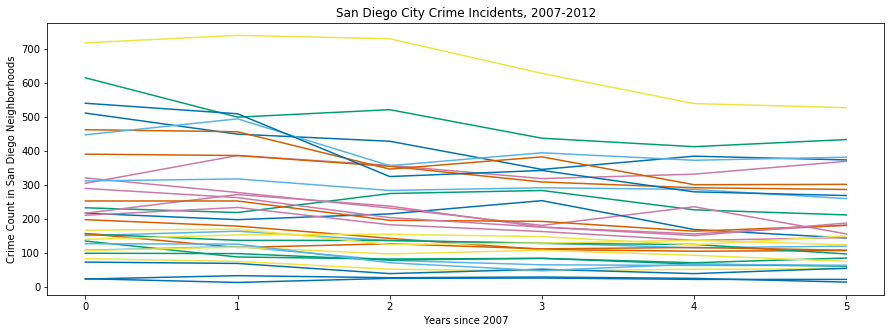

In [869]:
# graph crime incidents throughout years 2007 - 2012 for all San Diego City Neighborhoods
SD_city_crime_overtime()

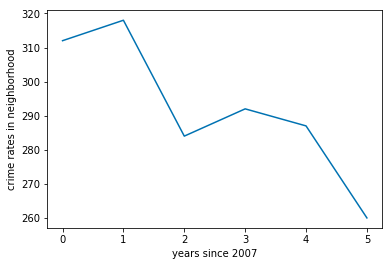

In [870]:
# accessing by each zipcode
plt.xlabel('years since 2007')
plt.ylabel('crime rates in neighborhood')
# color: each zipcode
_ = plt.plot(crimebread.T[:][11]) #La Jolla

In [871]:
#plot crime incidents in San Diego county for each zipcode over the years
def SD_County_Crime_Overtime():
    plt.figure(1,figsize=(15,5))
    plt.xlabel('Years since 2008')
    plt.ylabel('Number of Crime incidents')
    plt.title('San Diego County Crime incidents, 2008 - 2012')
    _ = plt.plot(SD_crimebread[:][:])

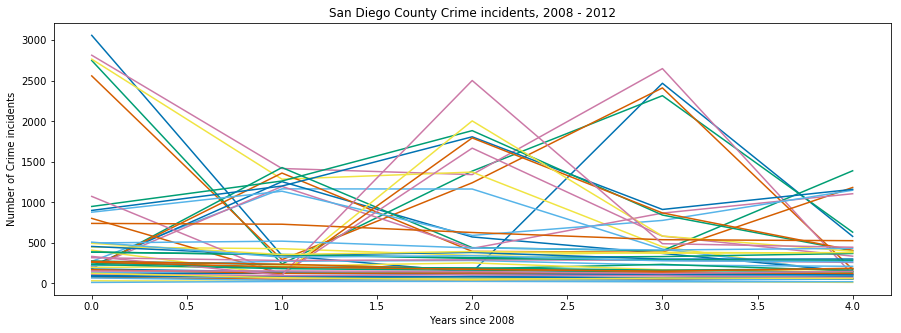

In [872]:
SD_County_Crime_Overtime()

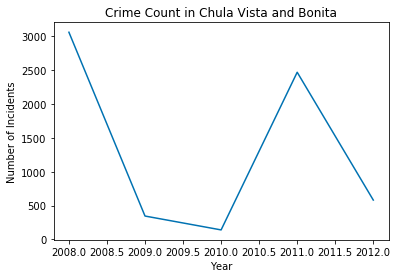

In [873]:
# print zipcode, crime count, and year of highest crime incidents
# print(df_sdcrime.iloc[df_sdcrime['crimecount'].idxmax])

highcrime_zip = df_sdcrime[df_sdcrime['zipcode'] == 91910]

plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.title('Crime Count in Chula Vista and Bonita')

_ = plt.plot(highcrime_zip['year'], highcrime_zip['crimecount'])

In [874]:
#find average crime rate in San Diego city for each year
def SDcity_average_crime():
    crime_2007 = crimebread[:][0]
    avgcrime_2007 = np.average(crime_2007)
    crime_2008 = crimebread[:][1]
    avgcrime_2008 = np.average(crime_2008)
    crime_2009 = crimebread[:][2]
    avgcrime_2009 = np.average(crime_2009)
    crime_2010 = crimebread[:][3]
    avgcrime_2010 = np.average(crime_2010)
    crime_2011 = crimebread[:][4]
    avgcrime_2011 = np.average(crime_2011)
    crime_2012 = crimebread[:][5]
    avgcrime_2012 = np.average(crime_2012)

    #plot average crime rate in San Diego city for each year
    avgcrime = [avgcrime_2007, avgcrime_2008, avgcrime_2009, avgcrime_2010, avgcrime_2011, avgcrime_2012]
    avgcrime_graph = plt.plot(year_range, avgcrime)
    plt.xlabel('Year')
    plt.ylabel('Average Number of Crimes')
    _ = plt.title('Average Crime Rates in San Diego, 2007-2012')

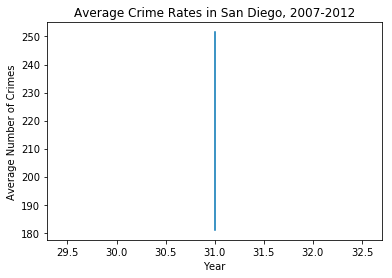

In [875]:
SDcity_average_crime()

In [876]:
#zipcode with highest crime count
#print(dfsort.iloc[dfsort['crimecount'].idxmax])

def compare_crime():
    cv_count = dfsort[dfsort['zipcode'] == 92130] 
    lj_count = dfsort[dfsort['zipcode'] == 92037]
    barriologan_count = dfsort[dfsort['zipcode'] == 92113]
    sanysidro_count = dfsort[dfsort['zipcode'] == 92173]

    cv_crime = cv_count['crimecount']
    lj_crime = lj_count['crimecount']
    barriologan_crime = barriologan_count['crimecount']
    sanysidro_crime = northpark_count['crimecount']

    plt.figure(1,figsize=(15,5))
    plt.title('Crime Incident Comparison')
    _ = plt.plot(lj_count['year'], lj_count['crimecount'], color = 'b')
    _ = plt.plot(cv_count['year'], cv_count['crimecount'], color = 'g')
    _ = plt.plot(barriologan_count['year'], barriologan_count['crimecount'], color = 'y')
    _ = plt.plot(sanysidro_count['year'], sanysidro_count['crimecount'], color = 'r')
    plt.legend(['La Jolla', 'Carmel Valley', 'Barrio Logan', 'San Ysidro'], loc='best')

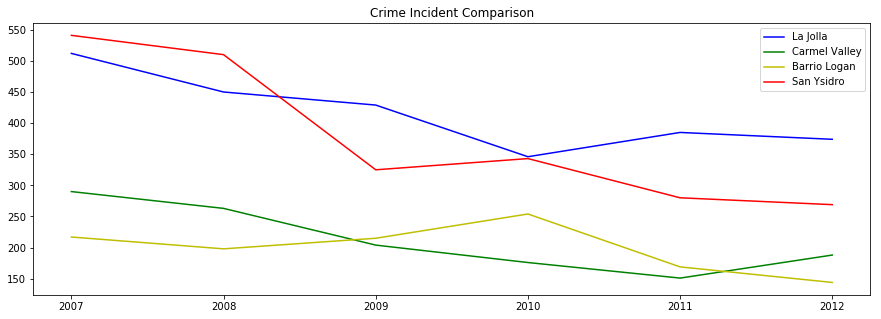

In [877]:
compare_crime()

In [878]:
#sum total number of crimes in San Diego city for each year
def SDcity_crime_total():
    year_range = [2007, 2008, 2009, 2010, 2011, 2012]
    total_2007 = np.sum(crimebread[:][0])
    total_2008 = np.sum(crimebread[:][1])
    total_2009 = np.sum(crimebread[:][2])
    total_2010 = np.sum(crimebread[:][3])
    total_2011 = np.sum(crimebread[:][4])
    total_2012 = np.sum(crimebread[:][5])
    totalcrime = [total_2007, total_2008, total_2009, total_2010, total_2011, total_2012]
    plt.title('Total Crimes Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Crimes')
    _ = plt.plot(year_range, totalcrime)
#print(totalcrime)

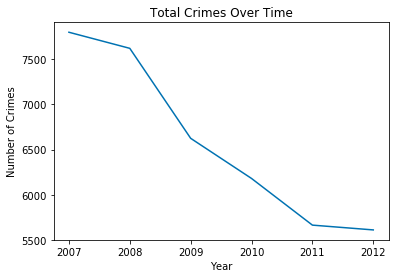

In [879]:
SDcity_crime_total()

# More Visualizations
To further conduct analysis, these visualizations allow for further exploration in levels of crime across San Diego

In [880]:
# number of neighborhoods that were above and below the city crime average
def compare_SDcity_avg():
    
    zipcrime_2007 = []
    zipcrime_2008 = []
    zipcrime_2009 = []
    zipcrime_2010 = []
    zipcrime_2011 = []
    zipcrime_2012 = []

    for j in range(len(crimebread)):
        for i in range(len(crimebread[j])):
            if j == 0:
                zipcrime_2007.append(crimebread[j][i])
            if j == 1:
                zipcrime_2008.append(crimebread[j][i])
            if j == 2:
                zipcrime_2009.append(crimebread[j][i])
            if j == 3:
                zipcrime_2010.append(crimebread[j][i])
            if j == 4:
                zipcrime_2011.append(crimebread[j][i])
            if j == 5:
                zipcrime_2012.append(crimebread[j][i])

    above_count0 = 0
    below_count0 = 0
    above_count1 = 0
    below_count1 = 0
    above_count2 = 0
    below_count2 = 0
    above_count3 = 0
    below_count3 = 0
    above_count4 = 0
    below_count4 = 0
    above_count5 = 0
    below_count5 = 0

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.00*h, '%d'%int(h),
                    ha='center', va='bottom')

    for i in range(len(totalcrime)):
        for j in range(len(zipcrime_2007)):
            if zipcrime_2007[j] > avgcrime_2007:
                above_count0+=1
            if zipcrime_2007[j] <= avgcrime_2007:
                below_count0+=1
        for j in range(len(zipcrime_2008)):
            if zipcrime_2008[j] > avgcrime_2008:
                above_count1+=1
            if zipcrime_2008[j] <= avgcrime_2008:
                below_count1+=1
        for j in range(len(zipcrime_2009)):
            if zipcrime_2009[j] > avgcrime_2009:
                above_count2+=1
            if zipcrime_2009[j] <= avgcrime_2009:
                below_count2+=1      
        for j in range(len(zipcrime_2010)):
            if zipcrime_2010[j] > avgcrime_2010:
                above_count3+=1
            if zipcrime_2010[j] <= avgcrime_2010:
                below_count3+=1      
        for j in range(len(zipcrime_2011)):
            if zipcrime_2011[j] > avgcrime_2011:
                above_count4+=1
            if zipcrime_2011[j] <= avgcrime_2011:
                below_count4+=1      
        for j in range(len(zipcrime_2012)):
            if zipcrime_2012[j] > avgcrime_2012:
                above_count5+=1
            if zipcrime_2012[j] <= avgcrime_2012:
                below_count5+=1  
            
    above = [above_count0, above_count1, above_count2, above_count3, above_count4, above_count5]
    below = [below_count0, below_count1, below_count2, below_count3, below_count4, below_count5]

    ind = np.arange(len(totalcrime))  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots(figsize = (10,8))
    rects1 = ax.bar(ind, below, width, color='b')

    rects2 = ax.bar(ind + width, above, width, color='r')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Number of Zipcodes')
    ax.set_title('Number of Zipcodes Above or Below Average Crime Count')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('2007', '2008', '2009', '2010', '2011', '2012'))

    ax.legend((rects1[0], rects2[0]), ('Below', 'Above'))

    autolabel(rects1)
    autolabel(rects2)

    plt.show()
    

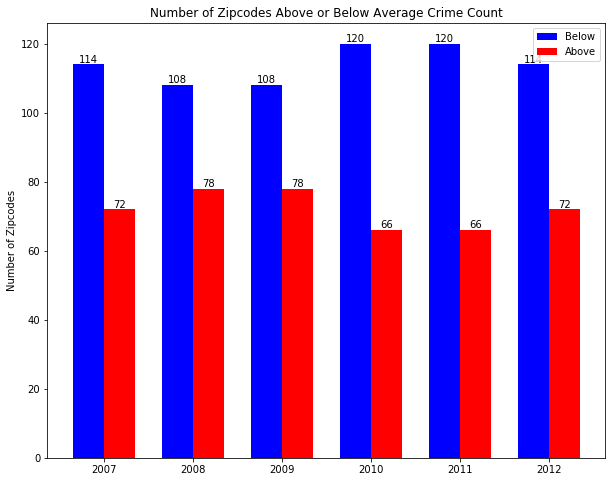

In [881]:
compare_SDcity_avg()

<Container object of 31 artists>

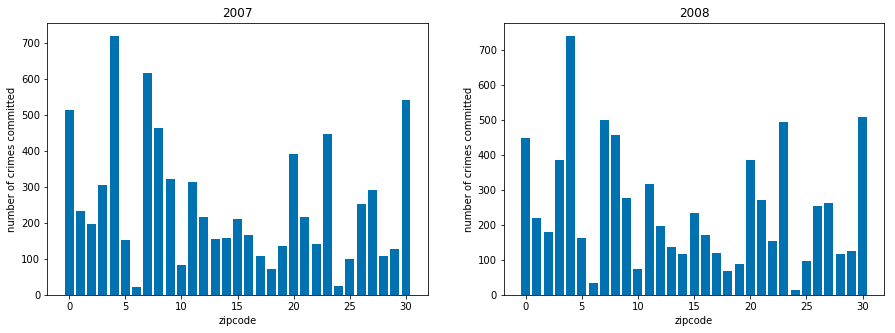

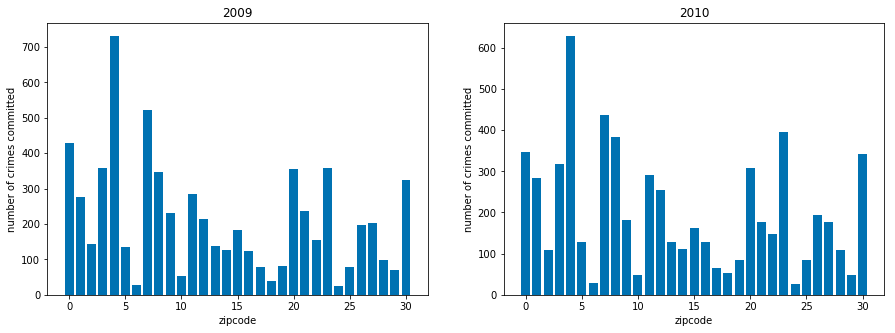

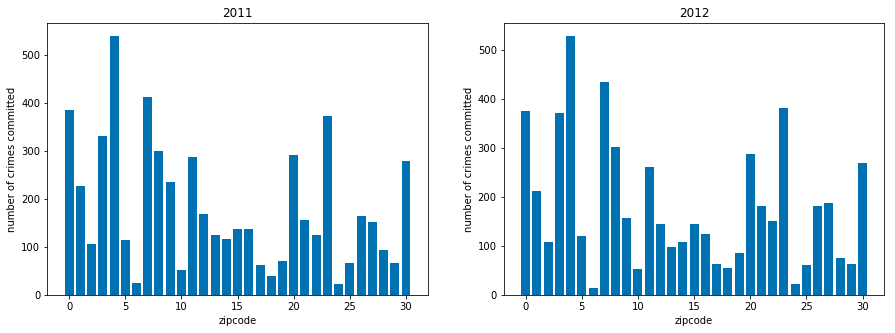

In [882]:
#graph the crime count numbers of individual zipcodes for each year

zipcrime_2007 = []
zipcrime_2008 = []
zipcrime_2009 = []
zipcrime_2010 = []
zipcrime_2011 = []
zipcrime_2012 = []

for j in range(len(crimebread)):
    for i in range(len(crimebread[j])):
        if j == 0:
            zipcrime_2007.append(crimebread[j][i])
        if j == 1:
            zipcrime_2008.append(crimebread[j][i])
        if j == 2:
            zipcrime_2009.append(crimebread[j][i])
        if j == 3:
            zipcrime_2010.append(crimebread[j][i])
        if j == 4:
            zipcrime_2011.append(crimebread[j][i])
        if j == 5:
            zipcrime_2012.append(crimebread[j][i])

plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
plt.title(year_list[0])
plt.xlabel('zipcode')
plt.ylabel('number of crimes committed')
plt.bar(list(range(len(zip_list))), zipcrime_2007)
plt.subplot(1,2,2)
plt.title(year_list[1])
plt.xlabel('zipcode')
plt.ylabel('number of crimes committed')
plt.bar(list(range(len(zip_list))), zipcrime_2008)


plt.figure(2,figsize=(15,5))
plt.subplot(1,2,1)
plt.title(year_list[2])
plt.xlabel('zipcode')
plt.ylabel('number of crimes committed')
plt.bar(list(range(len(zip_list))), zipcrime_2009)
plt.subplot(1,2,2)
plt.title(year_list[3])
plt.xlabel('zipcode')
plt.ylabel('number of crimes committed')
plt.bar(list(range(len(zip_list))), zipcrime_2010)


plt.figure(3,figsize=(15,5))
plt.subplot(1,2,1)
plt.title(year_list[4])
plt.xlabel('zipcode')
plt.ylabel('number of crimes committed')
plt.bar(list(range(len(zip_list))), zipcrime_2011)
plt.subplot(1,2,2)
plt.title(year_list[5])
plt.xlabel('zipcode')
plt.ylabel('number of crimes committed')
plt.bar(list(range(len(zip_list))), zipcrime_2012)

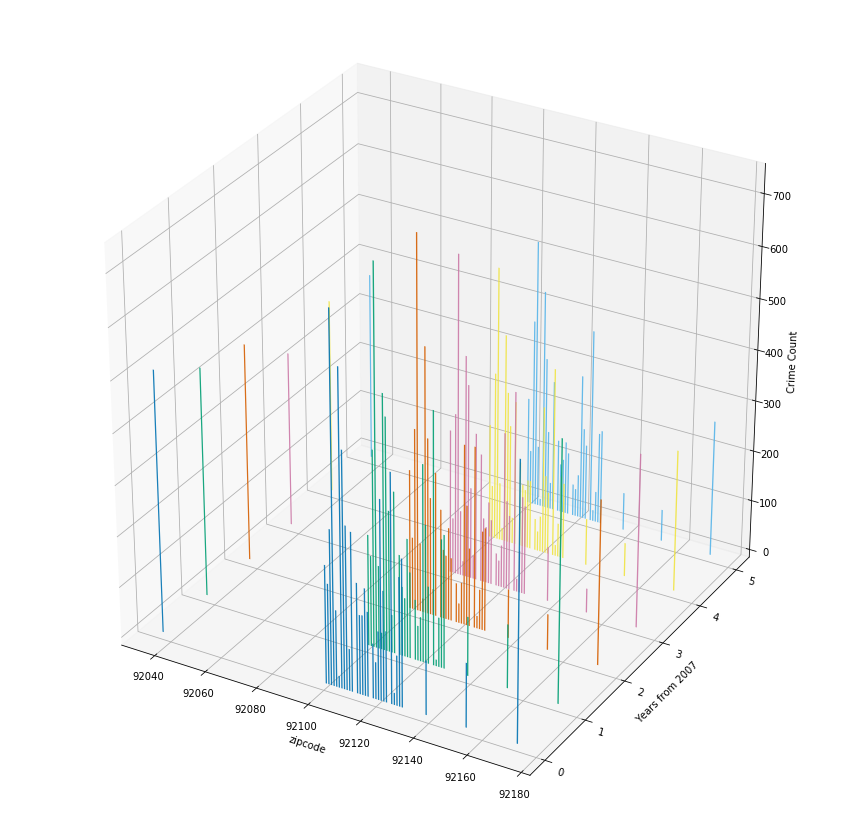

In [883]:
#create array that stores number of crime counts per year
numcr = []
for i in range(len(year_list)):
    numcr.append(list(crimebread3D[i][0][:]))

x = list(crimebread3D[0][1][:])

# create 3D graph 
fig = plt.figure(1, figsize=(15,15))

ax = fig.add_subplot(111, projection='3d')

for c, f in zip(['r', 'g', 'b', 'y', 'r', 'g'], [0, 1, 2, 3, 4, 5]):
    xs = x #zipcode
    z = numcr[f]
    ax.bar(xs, z, f, zdir = 'y', alpha = .9, width = .5)

ax.set_xlabel('zipcode') 
ax.set_ylabel('Years from 2007') 
ax.set_zlabel('Crime Count') 

ax.set_yticklabels(labels, rotation = -15, verticalalignment = 'baseline', horizontalalignment = 'left')
plt.show()



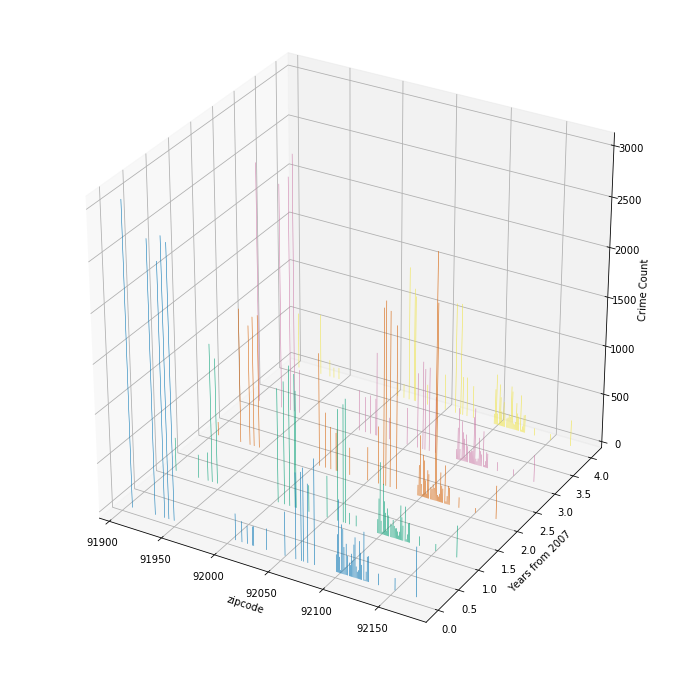

In [884]:
# 3D graph of crime incidents in SD county throughout the years
numcrime = []
for i in range(SD_total_yr):
    numcrime.append(list(SD_crimebread3D[i][0][:]))

x = list(SD_crimebread3D[0][1][:])

# create 3D graph 
fig = plt.figure(1, figsize=(12,12))

ax = fig.add_subplot(111, projection='3d')

for c, f in zip(['r', 'g', 'b', 'y', 'r'], [0, 1, 2, 3, 4]):
    xs = x #zipcode
    z = numcrime[f]
    ax.bar(xs, z, f, zdir = 'y', alpha = 1, width = .50)

ax.set_xlabel('zipcode') 
ax.set_ylabel('Years from 2007') 
ax.set_zlabel('Crime Count') 

plt.show()



# creating data in h5py loaf
cogs108h5 = h5py.File('cogs108.h5', 'a')
cogs108h5.create_dataset('crime_rate', data = crimebread )
cogs108h5.close()


cogs108h5 = h5py.File('cogs108.h5', 'a')
cogs108h5.create_dataset('crime_rate_3D', data = crimebread3D )
cogs108h5.close()

cogs108h5 = h5py.File('cogs108.h5', 'a')
cogs108h5.create_dataset('SD_crime_rate', data = SD_crimebread )
cogs108h5.close()

cogs108h5 = h5py.File('cogs108.h5', 'a')
cogs108h5.create_dataset('SD_crime_rate_3D', data = SD_crimebread3D )
cogs108h5.close()